In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [2]:
# def load_audio_files(path):
#     audio_files = []
#     labels = []
#     if 'fake' in path:
#         label = [1.0, 0.0]
#     else:
#         label = [0.0, 1.0]
#     for filename in os.listdir(path):
#         file_path = os.path.join(path, filename)
#         audio, sr = librosa.load(file_path, sr=44100)
#         mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
#         pad_width = 220 - mfccs.shape[1]
#         if pad_width > 0:
#             mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
#         else:
#             mfccs = mfccs[:, :220]
#         audio_files.append(mfccs)
#         labels.append(label)
#     return audio_files, labels

# def load_audio_files(path):
#     audio_files = []
#     labels = []
#     if 'fake' in path:
#         label = [1.0, 0.0]
#     else:
#         label = [0.0, 1.0]
#     for filename in os.listdir(path):
#         file_path = os.path.join(path, filename)
#         audio, sr = librosa.load(file_path, sr=44100)
#         if audio.shape[0] == 0: #0-bit file removal
#             continue
#         mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
#         pad_width = 5000 - mfccs.shape[1]
#         mfccs = np.pad(mfccs, pad_width = ((0, 0), (0, pad_width)), mode = 'constant')
#         audio_files.append(mfccs)
#         labels.append(label)
#     return audio_files, labels
def load(train):
    audio_files = []
    labels = []
    shapes = []
    for i in range(len(train)):
        file = train.iloc[i]
        file_path = file['path']
        audio, sr = librosa.load(file_path)
        if audio.shape[0] == 0: #0-bit file removal
            continue
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc = 40)
        shape = mfccs.shape
        shapes.append(shape)
        pad_width = 1666 - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width = ((0, 0), (0, pad_width)), mode = 'constant')
        if file['label'] == 'fake':
            label = [1.0, 0.0]
        else:
            label = [0.0, 1.0]
        audio_files.append(mfccs)
        labels.append(label)
    return audio_files, labels, shapes

In [3]:
# dataset_path = 'open/train'
train = pd.read_csv('train.csv')

In [4]:
train_files, labels, shape = load(train)

In [6]:
max(shape)

(40, 1666)

In [6]:
val_path = os.path.join(dataset_path, "validation")
val_fake_path = os.path.join(val_path, "fake")
val_real_path = os.path.join(val_path, "real")
val_fake_files, val_fake_labels = load_audio_files(val_fake_path)
val_real_files, val_real_labels = load_audio_files(val_real_path)

In [7]:
test_path = os.path.join(dataset_path, "testing")
test_fake_path = os.path.join(test_path, "fake")
test_real_path = os.path.join(test_path, "real")
test_fake_files, test_fake_labels = load_audio_files(test_fake_path)
test_real_files, test_real_labels = load_audio_files(test_real_path)

In [17]:
def combinedata(realfile, fakefile, reallabel, fakelabel):
    X = []
    Y = []
    for elem in realfile:
        X.append(elem)
    for elem in fakefile:
        X.append(elem)
    for elem in reallabel:
        Y.append(elem)
    for elem in fakelabel:
        Y.append(elem)
    return X, Y
X_train, Y_train = combinedata(train_real_files, train_fake_files, train_real_labels, train_fake_labels)
X_val, Y_val = combinedata(val_real_files, val_fake_files, val_real_labels, val_fake_labels)
X_test, Y_test = combinedata(test_real_files, test_fake_files, test_real_labels, test_fake_labels)
len(X_train), len(Y_train), len(X_val), len(Y_val), len(X_test), len(Y_test)

(10208, 10208, 2244, 2244, 816, 816)

In [18]:
X_train = np.array(X_train, dtype='object')
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.array(X_val, dtype='object')
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.array(X_test, dtype='object')
X_test = np.reshape(X_test, (*X_test.shape, 1))
Y_train = np.array(Y_train, dtype='object')
Y_val = np.array(Y_val, dtype='object')
Y_test = np.array(Y_test, dtype='object')
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((10208, 40, 220, 1), (2244, 40, 220, 1), (10208, 2), (2244, 2))

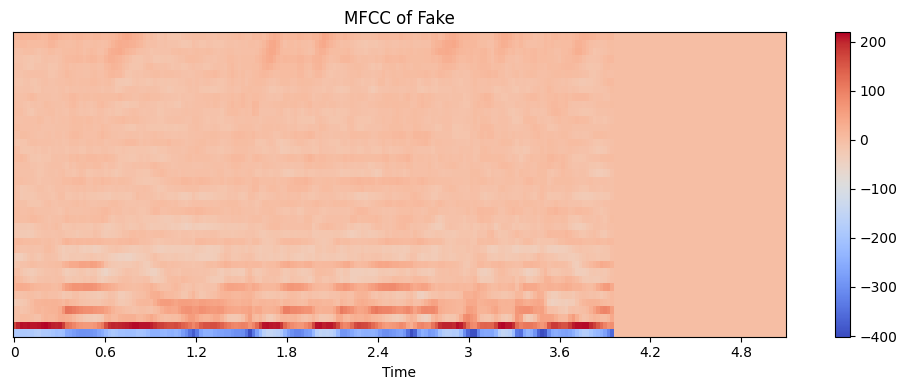

In [9]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(train_fake_files[0], x_axis='time')
plt.colorbar()
plt.title('MFCC of Fake')
plt.tight_layout()
plt.show()

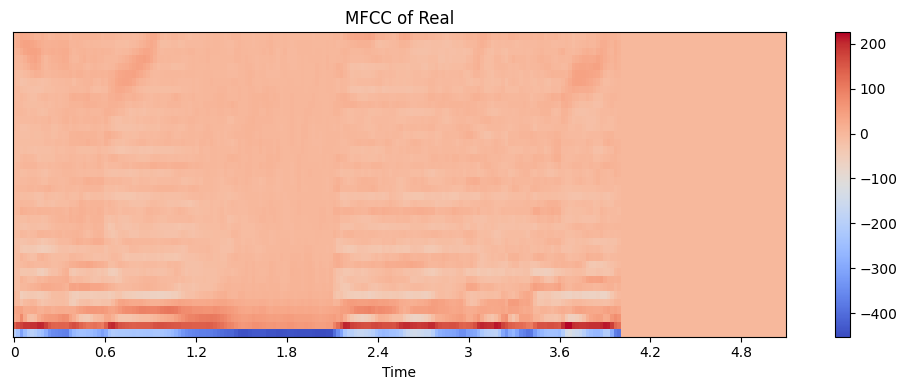

In [10]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(train_real_files[0], x_axis='time')
plt.colorbar()
plt.title('MFCC of Real')
plt.tight_layout()
plt.show()

In [19]:
input_shape = (40, 220, 1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 38, 218, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 109, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 107, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 53, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 27136)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,473,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,492,610 (13.32 MB)

 Trainable params: 3,492,610 (13.32 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)

In [23]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/50
 18/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9575 - loss: 0.1198

W0000 00:00:1719190965.422275     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


316/319 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9956 - loss: 0.0124

W0000 00:00:1719190968.203561     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9957 - loss: 0.0122 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

In [24]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('Test accuracy:', test_acc)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test accuracy: 1.0


# 논문 구현
Deepfake_Audio_Detection via MFCC Feartures Using Machine Learning
1. Preprocessing: duplicate files, 0-bit files 제거, different bit-rate in audio signal -> np.pad로 표준화 진행

2. Feature extraction: MFCCs 뿐 아니라 STFT(short-time Fourier transform = time domain signal -> time freq domain signal)도 사용

sr = 44100, n_mfcc = 270개, STFT-> PCA거치면서 65개로 추려냄


In [12]:
def load_audio_files(path):
    audio_files = []
    labels = []
    if 'fake' in path:
        label = [1.0, 0.0]
    else:
        label = [0.0, 1.0]
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        audio, sr = librosa.load(file_path, sr=44100)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = 220 - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width = ((0, 0), (0, pad_width)), mode = 'constant')
        audio_files.append(mfccs)
        labels.append(label)
    return audio_files, labels

In [18]:
def load_audio_files(path):
    audio_files = []
    labels = []
    shape = []
    if 'fake' in path:
        label = [1.0, 0.0]
    else:
        label = [0.0, 1.0]
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        audio, sr = librosa.load(file_path, sr=44100)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=270) 
        stft = librosa.stft
        shape.append(mfccs.shape)
#         print(mfccs.shape)
#         pad_width = 1000 - mfccs.shape[1]
#         mfccs = np.pad(mfccs, pad_width = ((0, 0), (0, pad_width)), mode = 'constant')
        audio_files.append(mfccs)
        labels.append(label)
    return audio_files, labels, shape
dataset_path = 'for-rerecorded/training/real'
audio_files, labels, shape = load_audio_files(dataset_path)#for-norm의 최대 길이 3332. mfcc처리 시간 약 30분(training > real만 했을때)
# audio, sr = librosa.load(dataset_path, sr=44100) #sr = sampling rate. 초당 44100개의 데이터 생성

In [7]:
file_path = 'FOR_dataset/for-norm/for-norm/training/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav'
audio, sr = librosa.load(file_path, sr=44100)
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40) 
stft = librosa.stft(audio) #둘다 shape[1]은 동일해서 똑같이 np.pad적용 가능.
stft_magnitude = np.abs(stft)
stft_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)
combined_features = np.vstack((mfccs, stft_db))

In [44]:
!git config --global user.name "yeonkyu"
!git config --global user.email "dusrb157@naver.com"
!git config --global init.defaultbranch main

In [47]:
!git pull origin main

From https://github.com/noahcho124/AI-deepfake-audio-detction
 * branch            main       -> FETCH_HEAD
Already up to date.


In [48]:
!git push --set-upstream origin main
# !git push origin main

Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 63.26 KiB | 7.91 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/noahcho124/AI-deepfake-audio-detction.git
   7b0178e..0c868bc  main -> main
branch 'main' set up to track 'origin/main'.


In [46]:
!git log

commit 580b430c1b4fa87b6099de5b1bc523c71a0b9dfd (HEAD -> main)
Author: yeonkyu <dusrb157@naver.com>
Date:   Mon Jun 24 22:18:44 2024 +0900

    Reinitialized due to git remote issue. Added mfcc and stft method for feature extraction.
